In [2]:
import torch  
from tqdm.autonotebook import tqdm
from datasets_tools import load_dataset, create_splits
from datasets_tools import get_occupation_labels, load_embeddings
from model_utils import get_model

/var/folders/z7/zxmjm5fs0gg5rjdp2rjzm4kw0000gn/T/ipykernel_29819/929152306.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
baseline = 'normal' 
#baseline = 'nogender'

#modeltype, nb_epochs = 'RoBERTa', 10
#modeltype, nb_epochs = 'DeBERTa', 3
modeltype, nb_epochs = 'DistilBERT', 3


datafolder = "/Users/fannyjourdan/Documents/doctorat/jupyterlab_OSIRIM/data"
if baseline == "normal":
  model_path = f"/Users/fannyjourdan/Documents/doctorat/jupyterlab_OSIRIM/models/BIOS_occupations_prediction/{modeltype}_occBIOS_{nb_epochs}epochs_g1"  # predict occ
elif baseline == 'nogender':
  model_path = f"/Users/fannyjourdan/Documents/doctorat/jupyterlab_OSIRIM/models/BIOS_occupations_prediction/{modeltype}_occBIOS_{nb_epochs}epochs_ng1"  # predict occ

else:
  print("Baseline not found")

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dt_X, gender_names, occ_names = load_dataset(datafolder, baseline=baseline)
splits, genders = create_splits(dt_X)
model, tokenizer = get_model(model_path, model_type = modeltype)
dt_X_train, dt_X_val, dt_X_test = splits
gender_train, gender_val, gender_test = genders

In [11]:
dt_X

,sentence,gender,label
0,She is also a Ronald D. Asmus Policy Entrepre...,0,3
1,He is a member of the AICPA and WICPA. Brent ...,1,23
2,Dr Aster has held teaching and research posit...,1,3
3,She currently works on CNN’s newest primetime...,0,12
4,He runs a boutique design studio attending cl...,1,13
...,...,...,...
388857,Fernando focuses his practice in all forms of...,1,14
388858,He maintains the trade policy site url. Rajan...,1,3
388859,"She teaches courses in Technical Writing, Com...",0,3
388860,He has been responsible for many facets of fi...,1,23


In [6]:
from utils import batch_predict

ntest = 50
features_ntest, labels_ntest = batch_predict(model.features, tokenizer, dt_X_test[:ntest], 32, device)
ypred_bis_ntest = model.end_model(features_ntest)

ypred_ntest, labels_ntest = batch_predict(model.forward, tokenizer, dt_X_test[:ntest], 32, device)

print("accuracy for classic model:", torch.mean((torch.argmax(ypred_ntest, -1) == labels_ntest).float()))
print("accuracy for model in 'two parts':", torch.mean((torch.argmax(ypred_bis_ntest, -1) == labels_ntest).float()))

100%|██████████| 2/2 [00:06<00:00,  3.20s/it]

accuracy for classic model: tensor(0.8600)
accuracy for model in 'two parts': tensor(0.8400)


In [12]:
datasets = dt_X_train, dt_X_val, dt_X_test
train_val_test_features, train_val_test_labels = load_embeddings(datasets,
                                                                 model=model,
                                                                 tokenizer=tokenizer,
                                                                 baseline=baseline,
                                                                 regenerate=False,
                                                                 model_type=modeltype,
                                                                 device=device)
train_features, val_features, test_features = train_val_test_features
train_labels, val_labels, test_labels = train_val_test_labels


train_labels, val_labels, test_labels = get_occupation_labels(dt_X_train, dt_X_val, dt_X_test, device)

In [13]:
ypred_test = model.end_model(test_features)
print("accuracy for classic model:", torch.mean((torch.argmax(ypred_test, -1) == test_labels).float()))

accuracy for classic model: tensor(0.8616)


In [9]:
train_features, train_features.shape

(tensor([[ 0.8497, -0.7409, -0.6220,  ..., -0.9276,  0.6046,  0.5081],
         [-0.4725,  0.0533, -0.5539,  ..., -0.0038, -1.4755,  0.1829],
         [-1.2480,  0.1682, -1.0883,  ...,  0.5235, -0.0657,  1.2301],
         ...,
         [ 0.7502, -0.7445, -0.5568,  ..., -1.1008,  0.5447,  0.5428],
         [-1.3762,  0.0918, -0.4574,  ..., -0.1524, -0.1649,  0.0748],
         [ 0.1080, -0.9622, -0.4966,  ...,  0.4012, -0.7115, -0.6903]]),
 torch.Size([272203, 768]))

In [10]:
val_features.shape, test_features.shape

(torch.Size([38886, 768]), torch.Size([77773, 768]))

In [11]:
train_labels.shape, val_labels.shape, test_labels.shape

(torch.Size([272203]), torch.Size([38886]), torch.Size([77773]))

In [12]:
gender_train.shape, gender_val.shape, gender_test.shape

((272203,), (38886,), (77773,))

# Train Model to predict gender

In [14]:
from train import train_genders
from train import LogisticMLP


retrain_gender_model = False
mlp_or_lin = 'mlp'
real_dataset = (train_features, val_features, test_features)
save_name = f'gender_pred/{modeltype}_{mlp_or_lin}_baseline_{baseline}.pt'
if retrain_gender_model:
  pg_model = train_genders(real_dataset, genders,
                          batch_size=2048, test_batch_size=8192,
                          learning_rate=1e-3, epochs=200,
                          train_on_validation_set=True,
                          model_type=mlp_or_lin,
                          save_path_and_name=save_name)
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  in_features = train_features.shape[1]
  state_dict = torch.load(save_name, map_location=torch.device(device))
  pg_model = train_genders(real_dataset, genders,
                          batch_size=2048, test_batch_size=8192,
                          learning_rate=1e-3, epochs=0,
                          train_on_validation_set=True,
                          model_type=mlp_or_lin,
                          state_dict=state_dict)

Final evaluation on the test set:

Val set: Average loss: 0.0759, Accuracy: 76517/77773 (98.385%)


Train to predict gender from occupation

Accuracy: 62.679%


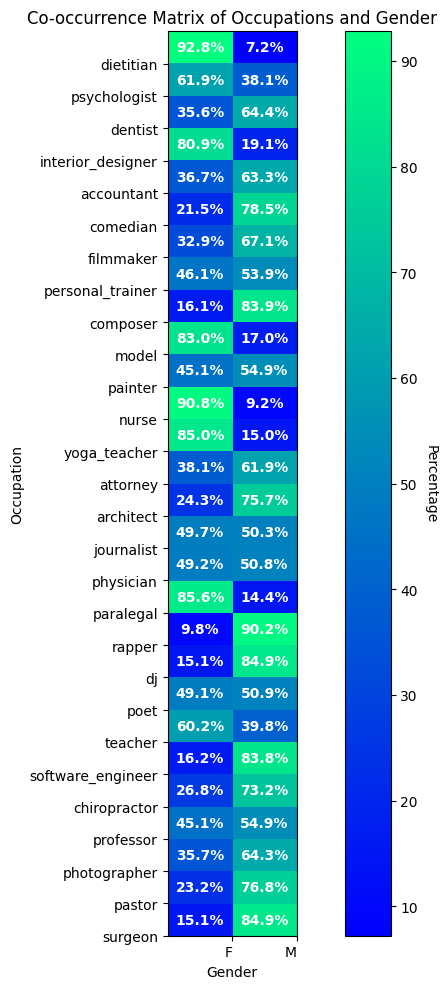

In [14]:
import numpy as np
from train import predict_gender_from_occupation

occupation_dataset = (train_labels, val_labels, test_labels)
predict_gender_from_occupation(occupation_dataset, genders)

# PART 1: Matrix decomposition

In [19]:
features = torch.cat((train_features, val_features, test_features), dim=0)

#refill the tensors:
n_train, n_val, n_test = len(train_features), len(val_features), len(test_features)
#train_features_new, val_features_new, test_features_new = features.split((n_train, n_val, n_test), dim=0)

In [21]:
from decomposition import decompose_choice

method_name = "ICA"
num_components = 20
decomposition_method = decompose_choice(method_name, num_components)


U, W = decomposition_method.decompose(features)

num_components = U.shape[1]
print("num_components:", num_components)

num_components: 20


In [ ]:
U.shape, W.shape

In [ ]:
U_train, U_val, U_test = U.split((n_train, n_val, n_test), dim=0)

# Visualisation of Latent Space

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from umap import UMAP 
from sklearn.cluster import KMeans

umap_2d = UMAP(n_components=2, init='random', random_state=0)
matrix = umap_2d.fit_transform(train_features)

gender_plot = gender_train
labels_plot = train_labels.cpu().numpy().astype(int)

gender_names = ['Female', 'Male']
occ_names = ['surgeon', 'pastor', 'photographer', 'professor', 'chiropractor', 'software_engineer', 'teacher', 'poet', 
             'dj', 'rapper', 'paralegal', 'physician', 'journalist', 'architect', 'attorney', 'yoga_teacher', 'nurse', 
             'painter', 'model', 'composer', 'personal_trainer', 'filmmaker', 'comedian', 'accountant', 'interior_designer', 
             'dentist', 'psychologist', 'dietitian']

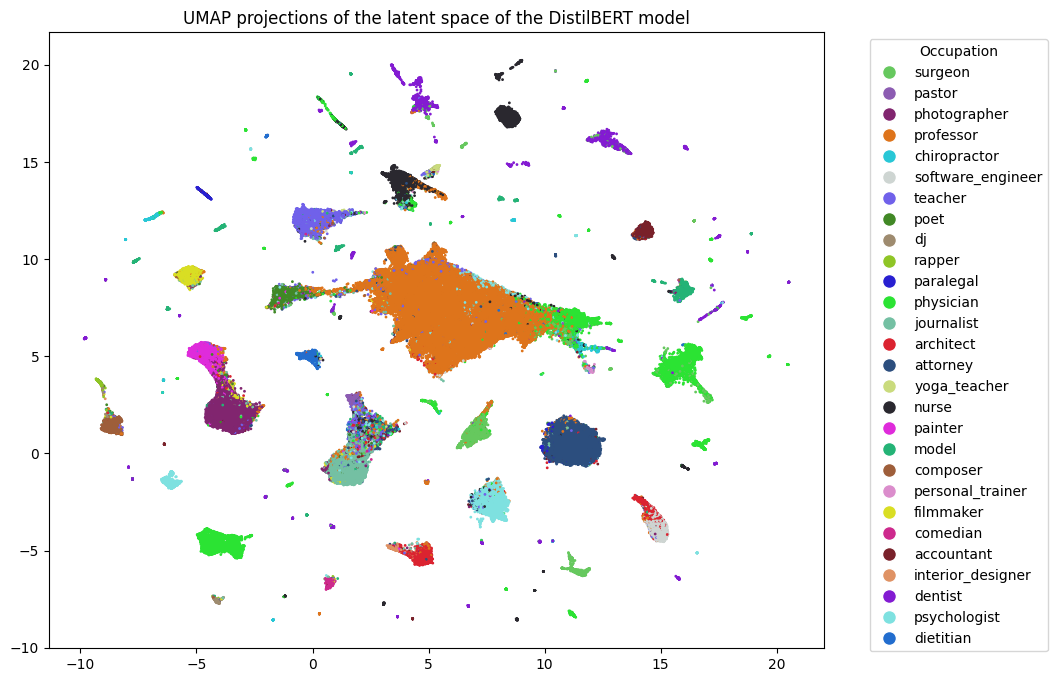

In [81]:
#occupations
#palette = sns.color_palette("husl", 28)

np.random.seed(3)
n_colors = 28
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(np.random.rand(1000, 3))
palette = kmeans.cluster_centers_
colors = [palette[label] for label in labels_plot]


plt.figure(figsize=(10, 8))
scatter = plt.scatter(matrix[:, 0], matrix[:, 1], c=colors, s=1)

legend_labels = {i: name for i, name in enumerate(occ_names)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10, label=name) for i, name in enumerate(occ_names)]
plt.legend(handles=handles, title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('UMAP projections of the latent space of the DistilBERT model')
plt.show()

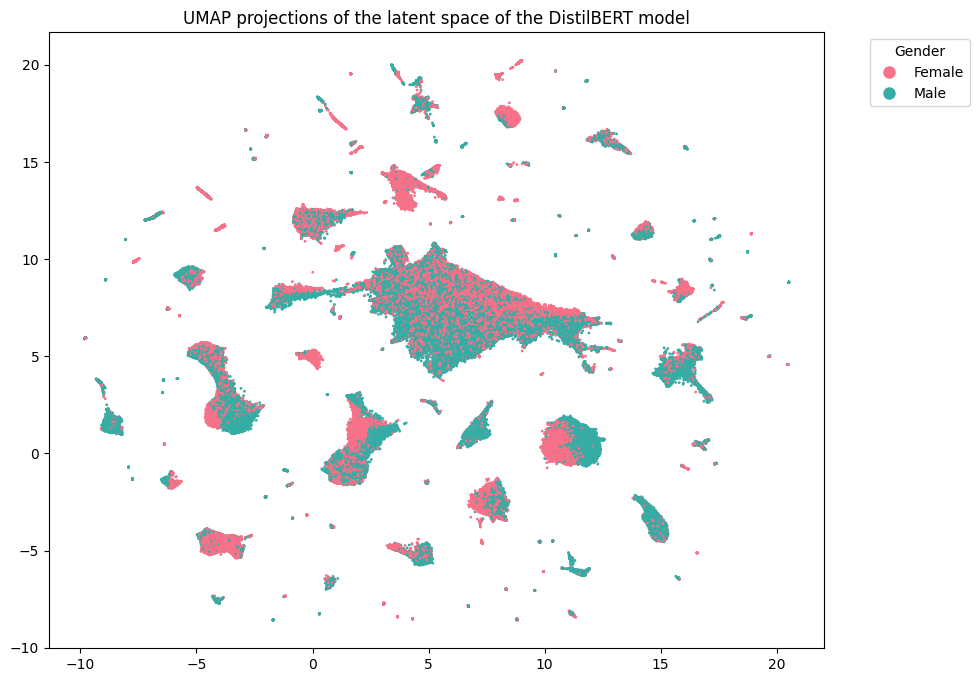

In [82]:
#gender
palette = sns.color_palette("husl", 2)
colors = [palette[label] for label in gender_plot]


plt.figure(figsize=(10, 8))
scatter = plt.scatter(matrix[:, 0], matrix[:, 1], c=colors, s=1)

legend_labels = {i: name for i, name in enumerate(gender_names)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10, label=name) for i, name in enumerate(gender_names)]
plt.legend(handles=handles, title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('UMAP projections of the latent space of the DistilBERT model')
plt.show()

# PART 2: Ranking concepts (Sobol)

In [ ]:
from concept_removal import sobol_importance_from_sample

sobol_nb_design = 50
sampled = 10_000

pg_model.eval() 
global_importance_gender, rel_errors_all_masks = sobol_importance_from_sample(train_features, U_train.numpy(),
                                                                              W.numpy(), pg_model,
                                                                              sampled=sampled,
                                                                              num_components=num_components,
                                                                              sobol_nb_design=sobol_nb_design, 
                                                                              device=device)

100%|██████████| 10000/10000 [01:13<00:00, 135.22it/s]


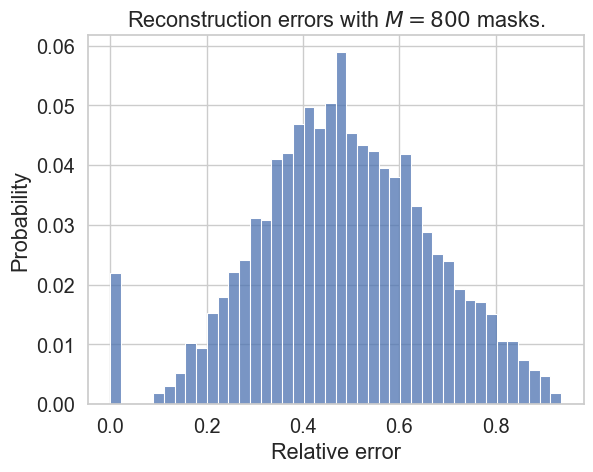

In [ ]:
from visualization import plot_reconstruction_error
import matplotlib.pyplot as plt

plot_reconstruction_error(rel_errors_all_masks)

In [ ]:
model.eval()
model_occ = lambda x: model.end_model(x)
global_importance_occ, _ = sobol_importance_from_sample(train_features, U_train.numpy(),
                                                        W.numpy(), model_occ,
                                                        sampled=sampled,
                                                        num_components=num_components,
                                                        sobol_nb_design=sobol_nb_design,
                                                        device=device)

100%|██████████| 10000/10000 [00:34<00:00, 288.99it/s]


In [ ]:
import pickle
pickle.dump(global_importance_gender, open(f'global_importance/{modeltype}_gi_gender_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"wb"))
pickle.dump(global_importance_occ, open(f'global_importance/gi_occupation_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"wb"))

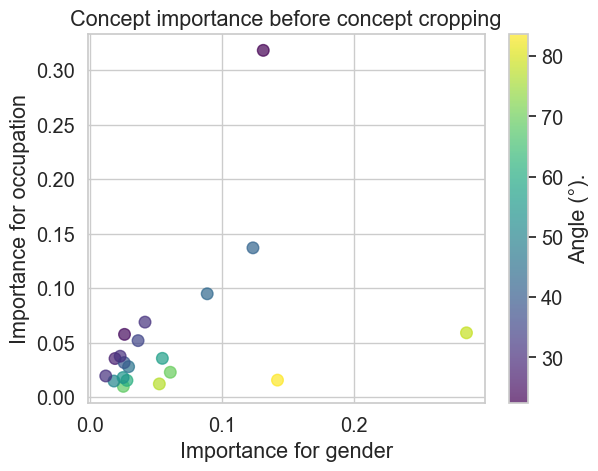

In [ ]:
from visualization import plot_co_importance
plot_co_importance(global_importance_occ, global_importance_gender)

# PART 3: Remove concepts

In [ ]:
import pickle
global_importance_gender = pickle.load(open(f'global_importance/gi_gender_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"rb"))
global_importance_occ = pickle.load(open(f'global_importance/gi_occupation_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"rb"))


In [ ]:
import numpy as np

W_gender_max = np.argmax(global_importance_gender)
f"idx={W_gender_max} concepts={global_importance_gender}"

'idx=15 concepts=[0.14178646 0.05222078 0.0249336  0.01785744 0.06052642 0.01160619\n 0.02766768 0.02475148 0.02891916 0.0186421  0.0255727  0.05451784\n 0.03610014 0.02582682 0.02251817 0.285038   0.04136292 0.08850759\n 0.1231896  0.13099605]'

In [ ]:
W_occ_max = np.argmax(global_importance_occ)
f"idx={W_occ_max} concepts={global_importance_occ}"

'idx=19 concepts=[0.01558847 0.01211336 0.00987153 0.01473458 0.02279549 0.01940823\n 0.01533164 0.0179653  0.02791209 0.0353743  0.03164991 0.03555777\n 0.05181019 0.05754033 0.03750351 0.05897734 0.06878164 0.0947592\n 0.13689709 0.31800368]'

In [ ]:
from concept_removal import crop_concepts, build_gender_neutral_features

nb_cpt_remov = 1
angle = np.arctan(global_importance_occ / global_importance_gender) * 180 / np.pi
W_no_gender, to_keep = crop_concepts(W.numpy(), angle, num_or_threshold=num_components-nb_cpt_remov)


train_a_no_gender = build_gender_neutral_features(U_train.numpy(), W_no_gender, to_keep)
val_a_no_gender = build_gender_neutral_features(U_val.numpy(), W_no_gender, to_keep)
test_a_no_gender = build_gender_neutral_features(U_test.numpy(), W_no_gender, to_keep)
train_a_no_gender.shape, val_a_no_gender.shape, test_a_no_gender.shape

((272203, 768), (38886, 768), (77773, 768))

# Training new model without gender information

In [ ]:
retrain = False
save_name = f'no_gender/pred_g_{method_name}{num_components}_cr{nb_cpt_remov}_{modeltype}_b_{baseline}.pt'
real_dataset = train_a_no_gender, val_a_no_gender, test_a_no_gender


def to_cuda_tensor(arr):
    return torch.Tensor(arr).type(torch.FloatTensor).to(device)
real_dataset = tuple(map(to_cuda_tensor, real_dataset))
if retrain:
  pg_no_gender_model = train_genders(real_dataset, genders,
                                     batch_size=2048, test_batch_size=8192,
                                     learning_rate=5e-4, epochs=100,
                                     train_on_validation_set=True,
                                     model_type='mlp',
                                     save_path_and_name=save_name)
else:
  state_dict = torch.load(save_name, map_location=torch.device(device))
  pg_no_gender_model = train_genders(real_dataset, genders,
                                     batch_size=2048, test_batch_size=8192,
                                     learning_rate=5e-4, epochs=0,
                                     train_on_validation_set=True,
                                     model_type='mlp',
                                     state_dict=state_dict,
                                     save_path_and_name=save_name)

Final evaluation on the test set:

Val set: Average loss: 1.8713, Accuracy: 51940/77773 (66.784%)


In [ ]:
from train import train_occupations

retrain = False
save_path = f'no_gender/pred_occ_{method_name}{num_components}_cr{nb_cpt_remov}_{modeltype}_b_{baseline}.pt'
real_dataset = train_a_no_gender, val_a_no_gender, test_a_no_gender
occupations = train_labels, val_labels, test_labels
if retrain:
  pocc_no_gender_model = train_occupations(real_dataset, occupations,
                                           batch_size=2048, val_batch_size=8192,
                                           learning_rate=5e-4, epochs=100,
                                           train_on_validation_set=False,
                                           model_type='mlp',
                                           save_path_and_name=save_path)
                                          
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  in_features = train_a_no_gender.shape[1]
  state_dict = torch.load(save_path, map_location=torch.device(device))
  pocc_no_gender_model = train_occupations(real_dataset, occupations,
                                           batch_size=2048, val_batch_size=8192,
                                           learning_rate=5e-4, epochs=0,
                                           train_on_validation_set=False,
                                           model_type='mlp',
                                           state_dict=state_dict,
                                           save_path_and_name=None)
                                           

Final evaluation on test set:

Val set: Average loss: 3.3035, Accuracy: 50637/77773 (65.109%)


# Visualisations

In [18]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import pickle
import numpy as np


%matplotlib inline
sns.set()

datafolderviz = "/Users/fannyjourdan/Documents/doctorat/GITHUB/TaCo/"

modeltype = "RoBERTa"
#modeltype = "DistilBERT"
#modeltype = "DeBERTa"

mlp_or_lin = "mlp"
method_name = "sSVD"
method_name2 = "PCA" #None
method_name3 = "ICA" #None
num_components = 20

min_gender = 0.62679

if modeltype == "RoBERTa":
    acc_gender_baseline1 = 0.96013
    acc_occ_baseline1 = 0.8639
    acc_gender_baseline2 = 0.79798
    acc_occ_baseline2 = 0.8608
elif modeltype == "DistilBERT":
    acc_gender_baseline1 = 0.98385
    acc_occ_baseline1 = 0.8616
    acc_gender_baseline2 = 0.84357
    acc_occ_baseline2 = 0.8591
elif modeltype == "DeBERTa":
    acc_gender_baseline1 = 0.69671
    acc_occ_baseline1 = 0.8591
    acc_gender_baseline2 = 0.70569
    acc_occ_baseline2 = 0.8584

In [19]:
concept_removed = list(range(0,num_components))

if method_name2 is None:
    save = f"plot_accuracy_{modeltype}_{method_name}{num_components}_{mlp_or_lin}"
else:
    if method_name3 is None:
        save = f"plot_accuracy_{modeltype}_{method_name}AND{method_name2}{num_components}_{mlp_or_lin}"
    else:
        save = f"plot_accuracy_{modeltype}_{method_name}AND{method_name2}AND{method_name3}{num_components}_{mlp_or_lin}"


plotmethod2, plotmethod3 = False, False 

In [20]:
nb_reps = 5

#list created with the run_concepts_remov.py file
l_acc_occ_method1 = pickle.load(open(datafolderviz + f'figures/list/l_occupation_acc_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_normal_{nb_reps}reps.pkl',"rb"))
l_acc_gender_method1 = pickle.load(open(datafolderviz + f'figures/list/l_gender_acc_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_normal_{nb_reps}reps.pkl',"rb"))
acc_occ = [acc_occ_baseline1] + [np.mean(sublist) for sublist in l_acc_occ_method1]
acc_gender = [acc_gender_baseline1] + [np.mean(sublist) for sublist in l_acc_gender_method1]


if method_name2 is not None:
    plotmethod2 = True
    l_acc_occ_method2 = pickle.load(open(datafolderviz + f'figures/list/l_occupation_acc_{modeltype}_{method_name2}{num_components}_{mlp_or_lin}_baseline_normal_{nb_reps}reps.pkl',"rb"))
    l_acc_gender_method2 = pickle.load(open(datafolderviz + f'figures/list/l_gender_acc_{modeltype}_{method_name2}{num_components}_{mlp_or_lin}_baseline_normal_{nb_reps}reps.pkl',"rb"))
    acc_occ_method2 = [acc_occ_baseline1] + [np.mean(sublist) for sublist in l_acc_occ_method2]
    acc_gender_method2 = [acc_gender_baseline1] + [np.mean(sublist) for sublist in l_acc_gender_method2]


if method_name3 is not None:
    plotmethod3 = True
    l_acc_occ_method3 = pickle.load(open(datafolderviz + f'figures/list/l_occupation_acc_{modeltype}_{method_name3}{num_components}_{mlp_or_lin}_baseline_normal_{nb_reps}reps.pkl',"rb"))
    l_acc_gender_method3 = pickle.load(open(datafolderviz + f'figures/list/l_gender_acc_{modeltype}_{method_name3}{num_components}_{mlp_or_lin}_baseline_normal_{nb_reps}reps.pkl',"rb"))
    acc_occ_method3 = [acc_occ_baseline1] + [np.mean(sublist) for sublist in l_acc_occ_method3]
    acc_gender_method3 = [acc_gender_baseline1] + [np.mean(sublist) for sublist in l_acc_gender_method3]

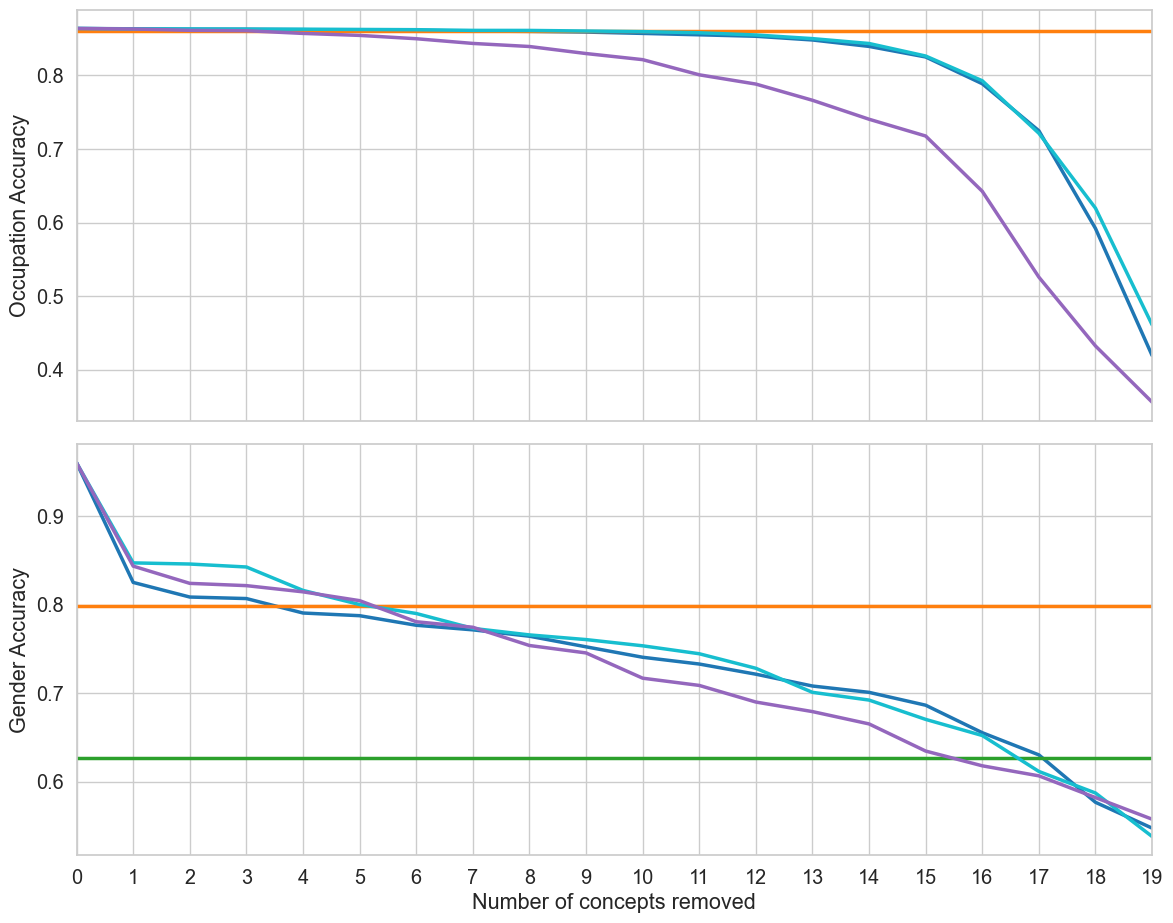

In [24]:
legend = False

# Define colors for the methods using a custom palette
our_method_color = "#1f77b4"  # Blue
baseline2_color = "#ff7f0e"  # Orange
min_gender_color = "#2ca02c"  # Green
method2_color = "#17becf"  # Cyan
method3_color = "#9467bd"  # Purple


sns.set(font_scale=1.3)
sns.set_style("white" if legend else "whitegrid")

num_points = len(concept_removed)
acc_occ_baseline2_line = [acc_occ_baseline2]*num_points
acc_gender_baseline2_line = [acc_gender_baseline2]*num_points
min_gender_line = [min_gender]*num_points

# Prepare the DataFrame
data = {
    "Number of concepts removed": concept_removed * (9 if plotmethod2 and plotmethod3 else 7 if plotmethod2 else 5),
    "Accuracy": acc_occ + acc_occ_baseline2_line + acc_gender + acc_gender_baseline2_line + min_gender_line + 
               (acc_occ_method2 + acc_gender_method2 if plotmethod2 else []) + 
               (acc_occ_method3 + acc_gender_method3 if plotmethod3 else []),
    "Method": (['Our method (Occupation)'] * num_points + 
               ['Baseline 2 (Occupation)'] * num_points + 
               ['Our method (Gender)'] * num_points + 
               ['Baseline 2 (Gender)'] * num_points + 
               ['Min Gender'] * num_points + 
               (['Method 2 (Occupation)'] * num_points + ['Method 2 (Gender)'] * num_points if plotmethod2 else []) + 
               (['Method 3 (Occupation)'] * num_points + ['Method 3 (Gender)'] * num_points if plotmethod3 else [])),
    "Metric": (['Occupation'] * num_points * 2 + 
               ['Gender'] * num_points * 3 + 
               (['Occupation'] * num_points + ['Gender'] * num_points if plotmethod2 else []) + 
               (['Occupation'] * num_points + ['Gender'] * num_points if plotmethod3 else []))
}

df = pd.DataFrame(data)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Define color palette
palette = {
    'Our method (Occupation)': our_method_color,
    'Our method (Gender)': our_method_color,
    'Baseline 2 (Occupation)': baseline2_color,
    'Baseline 2 (Gender)': baseline2_color,
    'Min Gender': min_gender_color,
    'Method 2 (Occupation)': method2_color,
    'Method 2 (Gender)': method2_color,
    'Method 3 (Occupation)': method3_color,
    'Method 3 (Gender)': method3_color
}

# Top plot for Occupation
sns.lineplot(data=df[df['Metric'] == 'Occupation'], x="Number of concepts removed", y="Accuracy", hue="Method", palette=palette, ax=ax1, linewidth=2.5)

# Bottom plot for Gender
sns.lineplot(data=df[df['Metric'] == 'Gender'], x="Number of concepts removed", y="Accuracy", hue="Method", palette=palette, ax=ax2, linewidth=2.5)

# Adjust legend
if legend:
    handles, labels = ax1.get_legend_handles_labels()
    # Remove duplicates and unnecessary entries
    unique_labels = ['Our method'] + ([method_name2 + ' variant'] if plotmethod2 else []) + ([method_name3 + ' variant'] if plotmethod3 else []) + ['Baseline 2', 'Min Gender']
    unique_handles = [Line2D([], [], color=our_method_color, label='Our method')] + ([Line2D([], [], color=method2_color, label='Method 2')] if plotmethod2 else []) + ([Line2D([], [], color=method3_color, label='Method 3')] if plotmethod3 else []) + [Line2D([], [], color=baseline2_color, label='Baseline 2'), Line2D([], [], color=min_gender_color, label='Min Gender')]
    fig.legend(handles=unique_handles, labels=unique_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1, frameon=True)

# Remove individual legends
ax1.get_legend().remove()
ax2.get_legend().remove()

# Add labels
ax1.set_ylabel('Occupation Accuracy')
ax2.set_ylabel('Gender Accuracy')
ax2.set_xlabel('Number of concepts removed')

# Set x-axis limits
ax1.set_xlim(0, len(concept_removed) - 1)
ax2.set_xlim(0, len(concept_removed) - 1)

# Adjust x-ticks
plt.xticks(ticks=concept_removed, labels=concept_removed)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

# if legend:
#   plt.savefig("figures/"+save+'_legend.png')
# else:
#   plt.savefig("figures/"+save+'.png')

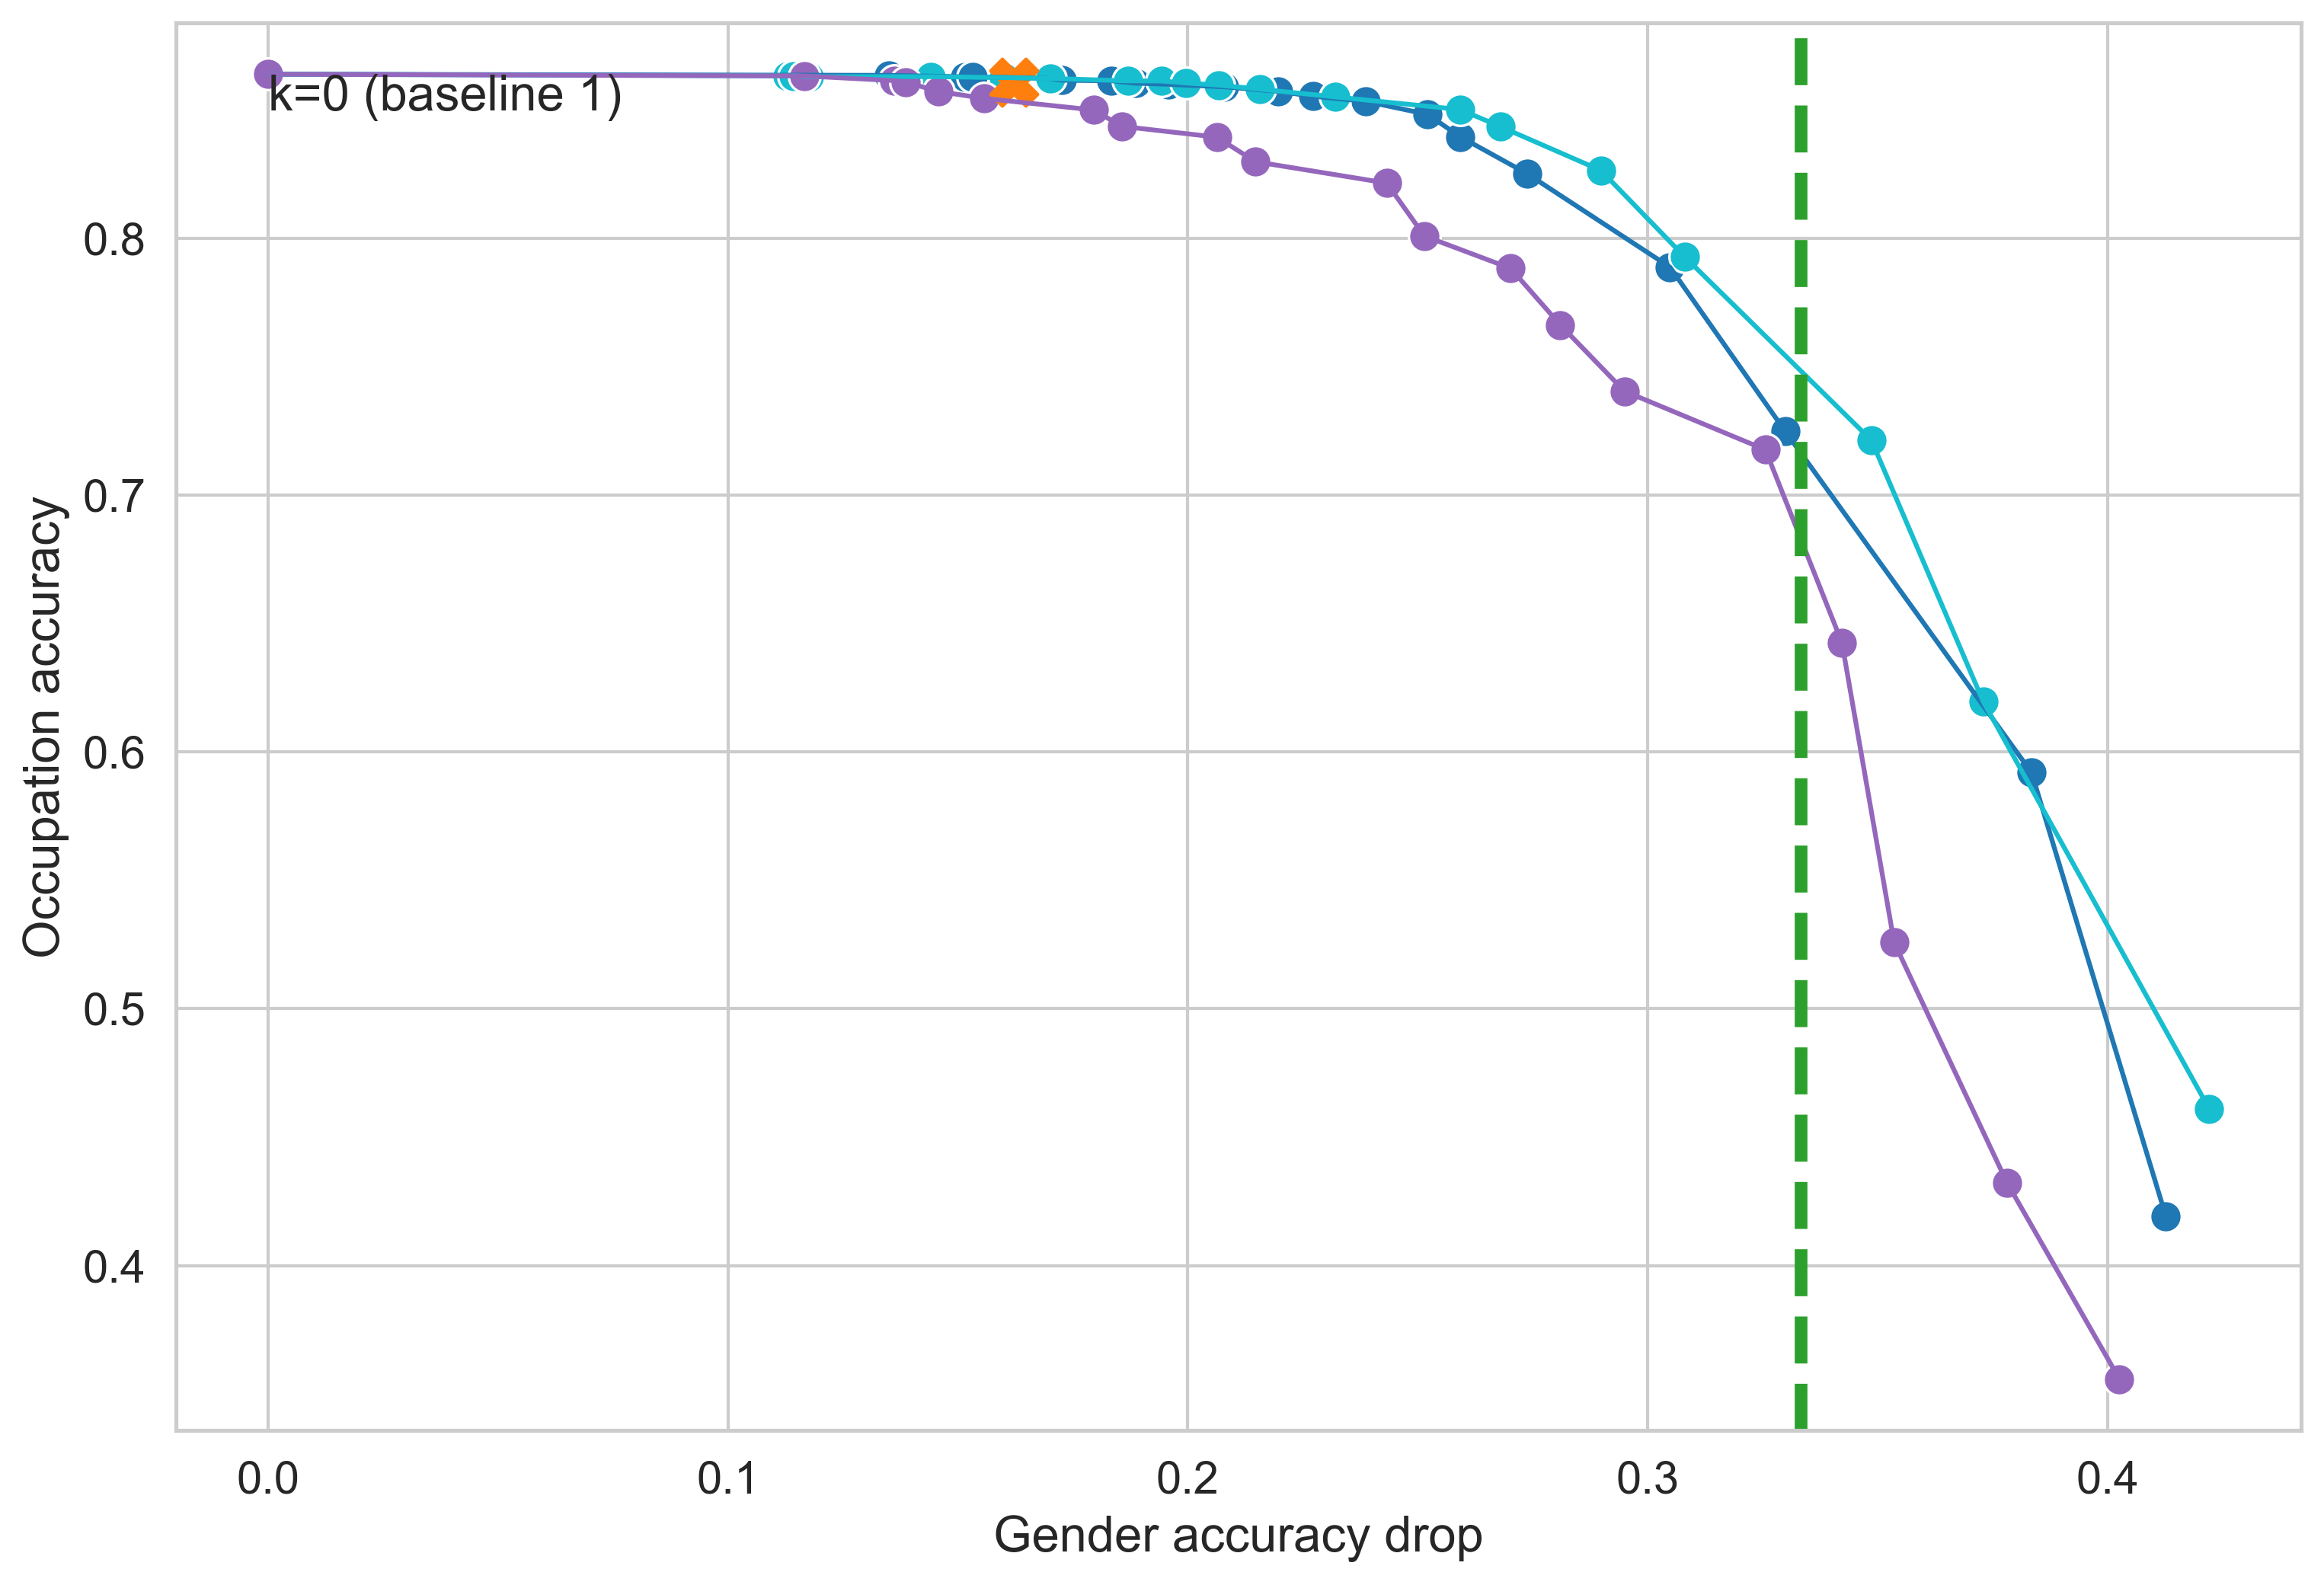

In [26]:
#With all methods:

legend = False

sns.set(font_scale=1.3)
sns.set_style("white" if legend else "whitegrid")

# Calculate gender accuracy drop
acc_gender_drop = [acc_gender_baseline1 - ag for ag in acc_gender]
acc_gender_baseline2_drop = acc_gender_baseline1 - acc_gender_baseline2
min_gender_drop = acc_gender_baseline1 - min_gender
acc_gender_method2_drop = [acc_gender_baseline1 - ag for ag in acc_gender_method2]
acc_gender_method3_drop = [acc_gender_baseline1 - ag for ag in acc_gender_method3]

# Custom colors
our_method_color = "#1f77b4"  # Blue
baseline2_color = "#ff7f0e"  # Orange
min_gender_color = "#2ca02c"  # Green
method2_color = "#17becf"  # Cyan
method3_color = "#9467bd"  # Purple

# Prepare DataFrame
data = {
    "Number of concepts removed": concept_removed,
    "Gender Accuracy Drop Model 1": acc_gender_drop,
    "Occupation Accuracy Model 1": acc_occ,
    "Gender Accuracy Drop Model 2": acc_gender_method2_drop,
    "Occupation Accuracy Model 2": acc_occ_method2,
    "Gender Accuracy Drop Model 3": acc_gender_method3_drop,
    "Occupation Accuracy Model 3": acc_occ_method3
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 8), dpi=300)

# Plot the data for Model 1
line1 = sns.lineplot(data=df, x="Gender Accuracy Drop Model 1", y="Occupation Accuracy Model 1", color=our_method_color, markersize=10, label= 'Our method')
sns.scatterplot(data=df, x="Gender Accuracy Drop Model 1", y="Occupation Accuracy Model 1", color=our_method_color, s=100)

# Plot the data for Model 2
sns.lineplot(data=df, x="Gender Accuracy Drop Model 2", y="Occupation Accuracy Model 2", color=method2_color, markersize=10, label= method_name2 + ' variant')
sns.scatterplot(data=df, x="Gender Accuracy Drop Model 2", y="Occupation Accuracy Model 2", color=method2_color, s=100)

# Plot the data for Model 3
sns.lineplot(data=df, x="Gender Accuracy Drop Model 3", y="Occupation Accuracy Model 3", color=method3_color, markersize=10, label= method_name3 + ' variant')
sns.scatterplot(data=df, x="Gender Accuracy Drop Model 3", y="Occupation Accuracy Model 3", color=method3_color, s=100)

# Add baseline points
plt.scatter([acc_gender_baseline2_drop], [acc_occ_baseline2], s=220, marker='X', color=baseline2_color)
existing_handles, existing_labels = plt.gca().get_legend_handles_labels()
existing_handles.append(Line2D([0], [0], marker='X', markersize=10, color=baseline2_color, linestyle='None'))
existing_labels.append('Baseline 2 (Bios-Neutral)')

# Add green line
plt.axvline(x=min_gender_drop, ymin=0, ymax=1, color=min_gender_color, linestyle='--', linewidth=4.0)
existing_handles.append(Line2D([], [], color=min_gender_color, linestyle='--', label='Green Line'))
existing_labels.append('Gender prediction from occupation')

# Add text annotations
keep = [0]#, 1, 16, 19]
for i in keep:
    row = df.iloc[i]
    text = f'k={int(row["Number of concepts removed"])}'  # Ensure k is an integer
    if i == 0:
        text = 'k=0 (baseline 1)'
    plt.text(row["Gender Accuracy Drop Model 1"], row["Occupation Accuracy Model 1"], text, ha='left', va='top')

# Set axis limits
plt.xlim([min(min(acc_gender_drop), min(acc_gender_method2_drop), min(acc_gender_method3_drop)) - 0.02, max(max(acc_gender_drop), max(acc_gender_method2_drop), max(acc_gender_method3_drop)) + 0.02])
plt.ylim([min(min(acc_occ), min(acc_occ_method2), min(acc_occ_method3)) - 0.02, max(max(acc_occ), max(acc_occ_method2), max(acc_occ_method3)) + 0.02])

# Add axis labels
plt.xlabel("Gender accuracy drop")
plt.ylabel("Occupation accuracy")

# Add legend
if legend:
    plt.legend(existing_handles, existing_labels, title='Method', loc='best')
else:
    line1.get_legend().remove()

plt.show()

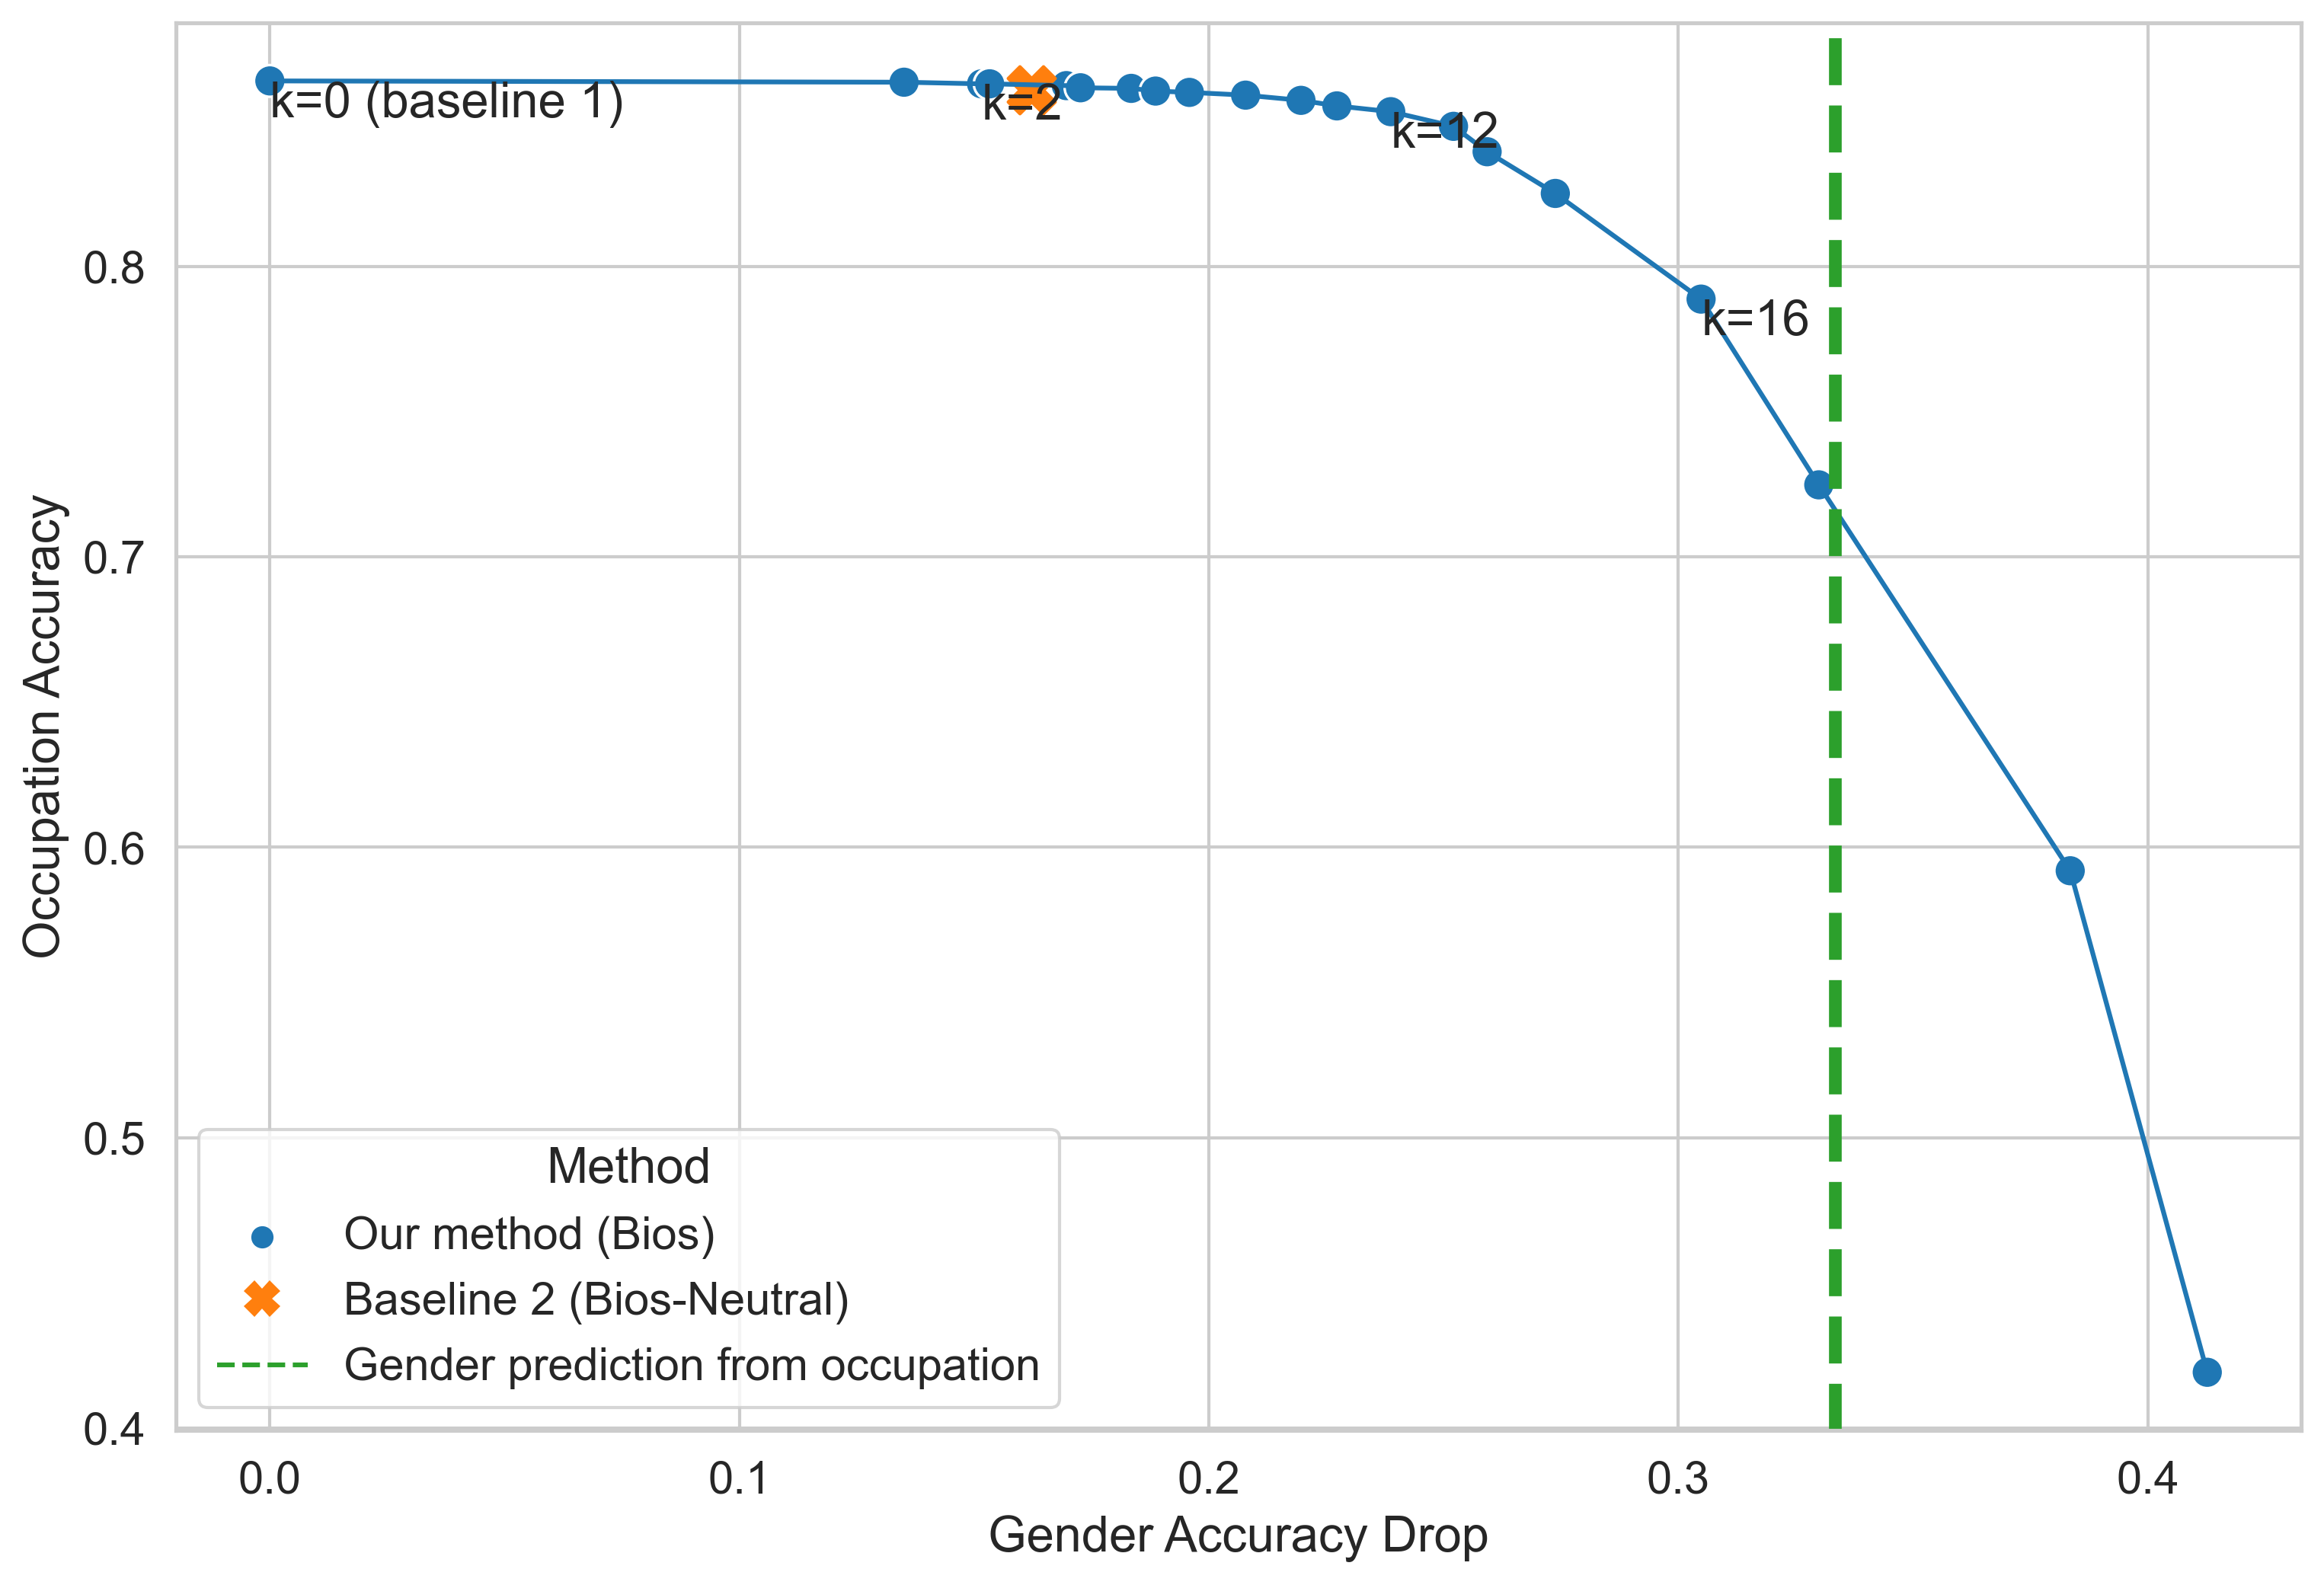

In [23]:
#With only one method:

# Calculate gender accuracy drop
max_gender = acc_gender[0]
acc_gender_drop = [max_gender - ag for ag in acc_gender]
acc_gender_baseline2_drop = max_gender - acc_gender_baseline2
min_gender_drop = max_gender - min_gender

# Prepare DataFrame
df = pd.DataFrame({
    "Number of concepts removed": concept_removed,
    "Gender Accuracy Drop": acc_gender_drop,
    "Occupation Accuracy": acc_occ,
    "Model": ['Our method (Bios)'] * len(acc_gender_drop)
})

plt.figure(figsize=(12, 8), dpi=300)

# Plot the data
sns.lineplot(data=df, x="Gender Accuracy Drop", y="Occupation Accuracy", hue="Model", palette=[our_method_color], markersize=10, legend=None)
sns.scatterplot(data=df, x="Gender Accuracy Drop", y="Occupation Accuracy", hue="Model", palette=[our_method_color], s=100)

# Add baseline points
plt.scatter([acc_gender_baseline2_drop], [acc_occ_baseline2], s=220, marker='X', color=baseline2_color)
existing_handles, existing_labels = plt.gca().get_legend_handles_labels()
existing_handles.append(Line2D([0], [0], marker='X', markersize=10, color=baseline2_color, linestyle='None'))
existing_labels.append('Baseline 2 (Bios-Neutral)')

# Add green line
plt.axvline(x=min_gender_drop, ymin=0, ymax=1, color=min_gender_color, linestyle='--', linewidth=4.0)
existing_handles.append(Line2D([], [], color=min_gender_color, linestyle='--', label='Green Line'))
existing_labels.append('Gender prediction from occupation')

# Add text annotations
keep = [0, 2, 12, 16]
for i in keep:
    row = df.iloc[i]
    text = f'k={row["Number of concepts removed"]}'
    if i == 0:
        text = 'k=0 (baseline 1)'
    plt.text(row["Gender Accuracy Drop"], row["Occupation Accuracy"], text, ha='left', va='top')

# Set axis limits
plt.xlim([min(acc_gender_drop) - 0.02, max(acc_gender_drop) + 0.02])
plt.ylim([min(acc_occ) - 0.02, max(acc_occ) + 0.02])

# Add legend
plt.legend(existing_handles, existing_labels, title='Method', loc='best')

plt.show()

# Explanations

In [ ]:
import pickle
import numpy as np

global_importance_gender = pickle.load(open(f'global_importance/gi_gender_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"rb"))
global_importance_occ = pickle.load(open(f'global_importance/gi_occupation_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"rb"))

In [ ]:
angle = np.arctan(global_importance_occ / global_importance_gender) * 180 / np.pi

sentences_train = []

for k in range(len(dt_X_train)):
    sentences_train.append(dt_X_train[k][0])

gender_pred_train = torch.argmax(pg_model(train_features), -1)
label_pred_train = torch.argmax(model.end_model(train_features), -1)

sentences_train = np.array(sentences_train)
train_labels = np.array(train_labels)
label_pred_train = np.array(label_pred_train)
gender_train = np.array(gender_train)
gender_pred_train = np.array(gender_pred_train)

names_g = ['F', 'M']
names_occ = ['surgeon', 'pastor', 'photographer', 'professor', 'chiropractor', 'software_engineer', 'teacher', 'poet', 'dj', 'rapper', 'paralegal', 'physician', 
              'journalist', 'architect', 'attorney', 'yoga_teacher', 'nurse', 'painter', 'model', 'composer', 'personal_trainer','filmmaker', 'comedian', 'accountant', 
              'interior_designer', 'dentist', 'psychologist', 'dietitian']


In [ ]:
from explaination import occlusion_concepts, viz_concepts, print_legend, print_legend2
import random

#sentences_type = "n bios for each concept"
#sentences_type = "random sentences"
sentences_type = "selected sentences"

if modeltype == "RoBERTa":
    l_concept_id = [15, 18, 19]
    colors = {0: "rgba(255, 102, 122, ",
              1: "rgba(179, 174, 54, ", 
              2: "rgba(45, 136, 179, "}
    
elif modeltype == "DistilBERT":
    l_concept_id = [13, 16, 17] 
    colors = {0: "rgba(91, 51, 255, ",
              1: "rgba(193, 51, 255, ", 
              2: "rgba(255, 51, 164, "}

angle = np.arctan(global_importance_occ / global_importance_gender) * 180 / np.pi
sorted_indices = sorted(range(len(angle)), key=lambda i: angle[i], reverse=False)
conceptnames = [sorted_indices.index(i) + 1 for i in l_concept_id]


if sentences_type == "n bios for each concept":
    n = 2 #number of bios for each concepts
    l_mip_ids, l_mip_sentences, l_mip_label, l_mip_predict_label, l_mip_gender, l_mip_predict_gender = [], [], [], [], [], []
    for concept_id in l_concept_id:
        mip_ids = np.argsort(U_train[:, concept_id].numpy())[::-1][:n]
        l_mip_ids.extend(mip_ids)
        l_mip_sentences.extend(sentences_train[mip_ids])
        l_mip_label.extend(train_labels[mip_ids])
        l_mip_predict_label.extend(label_pred_train[mip_ids])
        l_mip_gender.extend(gender_train[mip_ids])
        l_mip_predict_gender.extend(gender_pred_train[mip_ids])


else:
    if sentences_type == "selected sentences":
        if modeltype == "RoBERTa":
            l_mip_ids = [230484, 7029, 155554, 94984, 82706, 254362, 205272, 226245, 81814, 227333, 90373, 82798, 143102, 261617, 
                          219844, 125561, 39863, 246224, 265371, 155464, 123403, 229367]
        elif modeltype == "DistilBERT":
            l_mip_ids = [142293, 96384, 163939, 234490, 172463, 126052, 171392, 5941, 78211, 19448, 25222, 117517,
                         110738, 36185, 60128, 138762]
    
    elif sentences_type == "random sentences":
        l_mip_ids = random.sample(range(len(sentences_train)), 200)

    l_mip_sentences = sentences_train[l_mip_ids]
    l_mip_label = train_labels[l_mip_ids]
    l_mip_predict_label = label_pred_train[l_mip_ids]
    l_mip_gender = gender_train[l_mip_ids]
    l_mip_predict_gender = gender_pred_train[l_mip_ids]

In [ ]:
extract_fct, l_ignore_words = "word", ["’", "'", ",", ".", "...", "..", "....", ":", "!", "?", "", " ", "(", ")"]
#extract_fct, l_ignore_words = "clause", []

print("gender importance / occupation importance")
print_legend2(colors, l_concept_id, global_importance_gender, global_importance_occ, conceptnames)
#colors = print_legend(l_concept_id, global_importance_gender, global_importance_occ, conceptnames)

i = 0
for sentence in l_mip_sentences:
  print('sentence:', l_mip_ids[i])
  print('occupation: true label:', names_occ[int(l_mip_label[i])], '; predicted label:', names_occ[int(l_mip_predict_label[i])])
  print('gender: true label:', names_g[l_mip_gender[i]], '; predicted label:', names_g[l_mip_predict_gender[i]])

  phi = occlusion_concepts(sentence, model, tokenizer, W, l_concept_id, ignore_words = l_ignore_words, extract_fct = extract_fct, device = device)
  
  phi /= np.max(np.abs(phi)) + 1e-5
  viz_concepts(sentence, phi, colors, ignore_words = l_ignore_words, extract_fct = extract_fct)
  i += 1

gender importance / occupation importance


sentence: 142293
occupation: true label: surgeon ; predicted label: surgeon
gender: true label: M ; predicted label: M


sentence: 96384
occupation: true label: surgeon ; predicted label: surgeon
gender: true label: M ; predicted label: M


sentence: 163939
occupation: true label: dentist ; predicted label: dentist
gender: true label: M ; predicted label: M


sentence: 234490
occupation: true label: physician ; predicted label: physician
gender: true label: F ; predicted label: F


sentence: 172463
occupation: true label: surgeon ; predicted label: surgeon
gender: true label: M ; predicted label: M


sentence: 126052
occupation: true label: photographer ; predicted label: photographer
gender: true label: M ; predicted label: M


sentence: 171392
occupation: true label: professor ; predicted label: professor
gender: true label: M ; predicted label: M


sentence: 5941
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: F


sentence: 78211
occupation: true label: journalist ; predicted label: journalist
gender: true label: F ; predicted label: F


sentence: 19448
occupation: true label: photographer ; predicted label: photographer
gender: true label: M ; predicted label: M


sentence: 25222
occupation: true label: professor ; predicted label: professor
gender: true label: F ; predicted label: F


sentence: 117517
occupation: true label: professor ; predicted label: professor
gender: true label: M ; predicted label: M


sentence: 110738
occupation: true label: surgeon ; predicted label: attorney
gender: true label: M ; predicted label: M


sentence: 36185
occupation: true label: professor ; predicted label: professor
gender: true label: M ; predicted label: M


sentence: 60128
occupation: true label: composer ; predicted label: composer
gender: true label: M ; predicted label: M


sentence: 138762
occupation: true label: nurse ; predicted label: nurse
gender: true label: F ; predicted label: F
